# Imports

In [1]:
# Import necessary modules
from PyLCM.animation import *
from PyLCM.widget import *
from PyLCM.timestep_routine import *
from PyLCM.parameters import *

# Import user modifiable modules
from Post_process.analysis import *
from Post_process.print_plot import *

# Uncomment lines below when changing source files
#######################
%load_ext autoreload
%autoreload 2
#######################

# JAX
from jax import grad
from jax import random
from jax import jacfwd
import jax.numpy as jnp

from jax.config import config
config.update("jax_debug_nans", True)

/var/folders/pm/yr9p5vts11g53s85rr_h4kw8tlv16r/T/ipykernel_6527/3374762115.py:23: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


# JAX setup

In [2]:
# Generate array of JAX RNG for stochasticity in the code

rng_len = 1000
seed = 0

rng = np.zeros(rng_len)

key = random.PRNGKey(seed)
key, *subkeys = random.split(key, rng_len+1)

for i in range(rng_len):
  rng = rng.at[i].set( random.normal(subkeys[i], shape=(1,))[0] )


#key, subkey = random.split(key)
#normal_pseudorandom = random.normal(subkey, shape=(1,))
#float(normal_pseudorandom[0])

# Model initialisation

In [3]:
# SETUP
# Replaces model_init() function

# -model steering parameters
dt = 5. # s
nt = 10 #3600
n_particles = 5 #1000
max_z = 3000. # m
do_condensation = True
do_collision = True
switch_sedi_removal = False # not implemented?

# parcel parameters
T_parcel = 293.2 # K
P_parcel = 101300. # Pa
RH_parcel = 0.88 # -
w_parcel = 1. # ms-1
z_parcel = 0. # m

ascending_mode = "linear" # "sine", "in_cloud_oscillation"
time_half_wave_parcel = 600. # only for "sine", "in_cloud_oscillation" settings
S_lst = 0.

# entrainment parameters
switch_entrainment = True
stability_condition = "Stable" # "Unstable", "Neutral"
entrainment_start = 1000. # s
entrainment_end = 1030. # s
entrainment_rate = 0.05 # ?

# aerosol parameters
kohler_activation_radius = False
switch_kappa_koehler = False
mode_aero_init = "Random" # "Weighting_factor"

# aerosol modes
                # 1         # 2         # 3         # 4
N_aero      = [ 200.e6,     11.00e6,    0.72e6,     0.0e6 ]
mu_aero     = [ 1.e-6,      0.05e-6,    0.46e-6,    0.0e-6 ]
sigma_aero  = [ 3.,         1.60,       2.20,       0.0 ]
k_aero      = [ 1.,         1.6,        1.60,       1.6 ]

# timestep routine
display_mode = "text_fast" # "graphics"

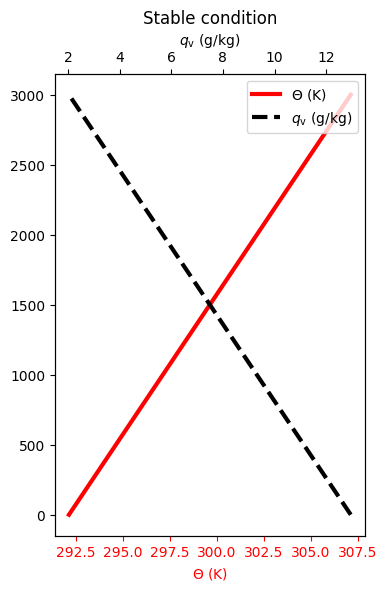

In [4]:
# create environment profile for entrainment

# qv_init same as q_parcel
qv_init = \
    RH_parcel * esatw(T_parcel) / ( P_parcel - RH_parcel * esatw(T_parcel) ) * r_a / rv
q_parcel = qv_init

qv_profiles, theta_profiles, z_env = \
    create_env_profiles(T_parcel, qv_init, z_parcel, P_parcel, stability_condition)

In [5]:
# model init
N_aero, mu_aero, sigma_aero, \
    qa_ts, qc_ts, qr_ts, \
    na_ts, nc_ts, nr_ts, \
    con_ts, act_ts, evp_ts, \
    dea_ts, acc_ts, aut_ts, precip_ts, \
    spectra_arr, \
    T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, \
    particles_list, particles_array, rc_liq_avg_array, rc_liq_std_array \
        = model_init(
            nt, n_particles,
            T_parcel, P_parcel, z_parcel, q_parcel,
            mode_aero_init, switch_kappa_koehler,
            N_aero, mu_aero, sigma_aero, k_aero
        )

# Test normal operation

In [25]:
"""
nt, dt, time_array, T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, \
qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, \
spectra_arr, con_ts, act_ts, evp_ts, dea_ts, acc_ts, aut_ts, precip_ts, particles_array, \
rc_liq_avg_array, rc_liq_std_array = \
    timesteps_function(
        dt, nt, n_particles, max_z, do_condensation, do_collision, switch_sedi_removal,
        T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, q_parcel,
        ascending_mode, time_half_wave_parcel,
        switch_entrainment, entrainment_start, entrainment_end, entrainment_rate,
        kohler_activation_radius, switch_kappa_koehler,
        display_mode,
        qv_profiles, theta_profiles,
        rm_spec,
        qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts,
        con_ts, act_ts, evp_ts,
        dea_ts, acc_ts, aut_ts, precip_ts,
        T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array,
        spectra_arr, particles_array, rc_liq_avg_array, rc_liq_std_array,
        particles_list,

        # JAX
        rng # not used in basic mode w/oentrainment, condensation, collision
    )
"""

'\nnt, dt, time_array, T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, spectra_arr, con_ts, act_ts, evp_ts, dea_ts, acc_ts, aut_ts, precip_ts, particles_array, rc_liq_avg_array, rc_liq_std_array =     timesteps_function(\n        dt, nt, n_particles, max_z, do_condensation, do_collision, switch_sedi_removal,\n        T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, q_parcel,\n        ascending_mode, time_half_wave_parcel,\n        switch_entrainment, entrainment_start, entrainment_end, entrainment_rate,\n        kohler_activation_radius, switch_kappa_koehler,\n        display_mode,\n        qv_profiles, theta_profiles,\n        rm_spec,\n        qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts,\n        con_ts, act_ts, evp_ts,\n        dea_ts, acc_ts, aut_ts, precip_ts,\n        T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array,\n        spectra_arr, particles_array, rc_liq_avg_array, rc_liq_std_array,\n        particle

In [17]:

nt, \
dt, \
time_array, \
T_parcel_array, \
RH_parcel_array, \
q_parcel_array, \
z_parcel_array, \
qa_ts, \
qc_ts, \
qr_ts, \
na_ts, \
nc_ts, \
nr_ts, \
con_ts, \
act_ts, \
evp_ts, \
dea_ts, \
acc_ts, \
aut_ts, \
precip_ts, \
rc_liq_avg_array, \
rc_liq_std_array = \
timesteps_function(
    dt, nt, n_particles, max_z, do_condensation, do_collision, switch_sedi_removal,
    T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, q_parcel,
    ascending_mode, time_half_wave_parcel, S_lst,
    switch_entrainment, entrainment_start, entrainment_end, entrainment_rate,
    kohler_activation_radius, switch_kappa_koehler,
    display_mode,
    jnp.array(qv_profiles), jnp.array(theta_profiles),
    jnp.array(rm_spec),
    jnp.array(qa_ts), jnp.array(qc_ts), jnp.array(qr_ts), jnp.array(na_ts), jnp.array(nc_ts), jnp.array(nr_ts),
    jnp.array(con_ts), jnp.array(act_ts), jnp.array(evp_ts),
    jnp.array(dea_ts), jnp.array(acc_ts), jnp.array(aut_ts), jnp.array(precip_ts),
    jnp.array(T_parcel_array), jnp.array(RH_parcel_array), jnp.array(q_parcel_array), jnp.array(z_parcel_array),
    jnp.array(spectra_arr), jnp.array(particles_array), jnp.array(rc_liq_avg_array), jnp.array(rc_liq_std_array),
    particles_list,

    # JAX
    rng, # not used in basic mode w/o entrainment, condensation, collision
    False
)


value: Time (s)  z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg)
500.0, 500.0, 290.5393371582031, 12.058627128601074, 91.40486907958984, 0.08645376563072205, 3.25248122215271, 0.0, 84.6880111694336, 42.3440055847168


# Auto diff

In [6]:
grad_timesteps_function = jacfwd(
    timesteps_function, (0,7,8,9,10,11,12), #allow_int=True
)

In [7]:
result = grad_timesteps_function(
    dt, nt, n_particles, max_z, do_condensation, do_collision, switch_sedi_removal,
    T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, q_parcel,
    ascending_mode, time_half_wave_parcel, S_lst,
    switch_entrainment, entrainment_start, entrainment_end, entrainment_rate,
    kohler_activation_radius, switch_kappa_koehler,
    display_mode,
    jnp.array(qv_profiles), jnp.array(theta_profiles),
    jnp.array(rm_spec),
    jnp.array(qa_ts), jnp.array(qc_ts), jnp.array(qr_ts), jnp.array(na_ts), jnp.array(nc_ts), jnp.array(nr_ts),
    jnp.array(con_ts), jnp.array(act_ts), jnp.array(evp_ts),
    jnp.array(dea_ts), jnp.array(acc_ts), jnp.array(aut_ts), jnp.array(precip_ts),
    jnp.array(T_parcel_array), jnp.array(RH_parcel_array), jnp.array(q_parcel_array), jnp.array(z_parcel_array),
    jnp.array(spectra_arr), jnp.array(particles_array), jnp.array(rc_liq_avg_array), jnp.array(rc_liq_std_array),
    particles_list,

    # JAX
    rng, # not used in basic mode w/o entrainment, condensation, collision
    True
)


# TRY: https://github.com/google/jax/issues/475 to debug NANs

one
two
three
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in jit(mul). Because jax_config.debug_nans.value and/or config.jax_debug_infs is set, the de-optimized function (i.e., the function as if the `jit` decorator were removed) was called in an attempt to get a more precise error message. However, the de-optimized function did not produce invalid values during its execution. This behavior can result from `jit` optimizations causing the invalid value to be produced. It may also arise from having nan/inf constants as outputs, like `jax.jit(lambda ...: jax.numpy.nan)(...)`. 

It may be possible to avoid the invalid value by removing the `jit` decorator, at the cost of losing optimizations. 

If you see this error, consider opening a bug report at https://github.com/google/jax.

In [28]:
result

((Array(0, dtype=int32, weak_type=True),
  Array(0, dtype=int32, weak_type=True),
  Array(0, dtype=int32, weak_type=True),
  Array(0, dtype=int32, weak_type=True),
  Array(0, dtype=int32, weak_type=True),
  Array(0, dtype=int32, weak_type=True),
  Array(0, dtype=int32, weak_type=True)),
 (Array(1., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True)),
 (Array(10., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True)),
 (Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Arra

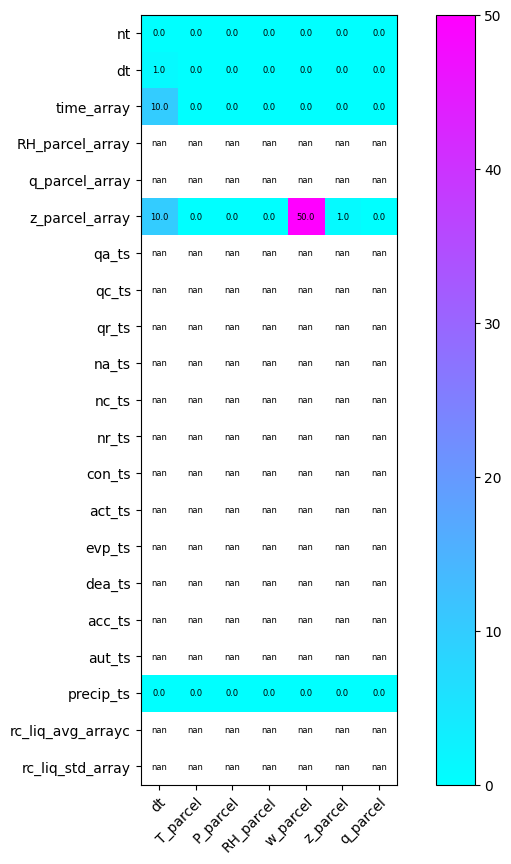

In [29]:
result_arr = np.abs(np.array(result))

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

xlabels = [
    "dt",
    "T_parcel",
    "P_parcel",
    "RH_parcel",
    "w_parcel",
    "z_parcel",
    "q_parcel"
    ]
ylabels = [
    "nt",
    "dt",
    "time_array",
    "RH_parcel_array",
    "q_parcel_array",
    "z_parcel_array",
    "qa_ts",
    "qc_ts",
    "qr_ts",
    "na_ts",
    "nc_ts",
    "nr_ts",
    "con_ts",
    "act_ts",
    "evp_ts",
    "dea_ts",
    "acc_ts",
    "aut_ts",
    "precip_ts",
    "rc_liq_avg_arrayc",
    "rc_liq_std_array"
]

fig, ax = plt.subplots(figsize=[10,10])

im = ax.imshow(result_arr, cmap='cool')#, norm=LogNorm())

ax.set_xticks(np.arange(len(xlabels)), labels=xlabels)
ax.set_yticks(np.arange(len(ylabels)), labels=ylabels)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(ylabels)):
    for j in range(len(xlabels)):
        #text = ax.text(j, i, np.around(result_arr[i, j],3),
        text = ax.text(j, i, result_arr[i, j],
                       ha="center", va="center", color="black", fontsize=6)

fig.colorbar(im, ax=ax)
plt.show()

In [ ]:
np.log(1.001)

Array(0.00099955, dtype=float32, weak_type=True)

In [ ]:
import jax

def test_func1(x,y):
    for i in range(0,len(y)):
        #jax.debug.print("{i}",i=i)
        y = y.at[i].set(x*i)
        jax.debug.print("{y}",y=y)
    return y[2]

def test_func2(x,y,z):

    a = x*y
    b = 2*z

    return a,b


test_grad = jacfwd(test_func2, (0,1,2))

#x = 10.
#y = jax.numpy.zeros(3)

x=10.;y=10.;z=10.

#print(x,y)

test_res = test_grad(x,y,z)
test_res

# da/dx ; da/dy ; da/dz
# db/dx ; db/dy ; db/dz

((Array(10., dtype=float32, weak_type=True),
  Array(10., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True)),
 (Array(0., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True),
  Array(2., dtype=float32, weak_type=True)))

In [ ]:
# from jax import jacfwd, jacrev

# # Isolate the function from the weight matrix to the predictions
# f = lambda W: predict(W, b, inputs)

# J = jacfwd(f)(W)
# print("jacfwd result, with shape", J.shape)
# print(J)

# J = jacrev(f)(W)
# print("jacrev result, with shape", J.shape)
# print(J)

In [ ]:
# import jax
# import jax.numpy as np

# def my_function(inputs):
#     # Define a function that computes multiple outputs
#     output1 = inputs[0] ** 2
#     output2 = np.sin(inputs[1])
#     output3 = inputs[0] * inputs[1]
#     return np.array([output1, output2, output3])

# # Example usage:
# inputs = np.array([2.0, 1.0])  # Example input values

# # Use jax.jacfwd to compute the Jacobian matrix
# jacobian_matrix = jax.jacfwd(my_function)(inputs)

# print("Jacobian Matrix:")
# print(jacobian_matrix)